In [2]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
groq_api_key = os.getenv("GROQ_API_KEY")

In [4]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")

In [5]:
llm.invoke("What is the capital of India?")

AIMessage(content='The capital of India is **New Delhi**. \n', response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 16, 'total_tokens': 29, 'completion_time': 0.023636364, 'prompt_time': 0.0012656, 'queue_time': 0.25192066, 'total_time': 0.024901964}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-f9a996f4-8ec5-4144-8c6d-2a638f9e7621-0')

In [6]:
from langgraph.graph.message import add_messages

In [7]:
class ChatbotState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [8]:
def chat_node(state: ChatbotState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [15]:
graph = StateGraph(ChatbotState)

graph.add_node("chat_node", chat_node)

graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", END)

chatbot = graph.compile()

In [16]:
chatbot

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<messages>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object object at 0x000001A957AAE6E0>, skip_none=False, mapper=_get_state_key(recurse=False))]), ChannelWrite<start:chat_node>(recurse=True, writes=[ChannelWriteEntry(channel='start:chat_node', value='__start__', skip_none=False, mapper=None)])]), 'chat_node': PregelNode(config={'tags': []}, channels={'messages': 'messages'}, triggers=['start:chat_node'], mapper=functools.partial(<function _coerce_state at 0x000001A958DC28E0>, <class '__main__.ChatbotState'>), writers=[ChannelWrite<chat_node,messages>(recurse=True, writes=[ChannelWriteEntry(channel='chat_node', value='chat_node', skip_none=False, mapper=None), ChannelWriteEntry(channel='messages', value=<object object at 0x000001A957AAE6E0>, skip_none=False, mapper=_get_state_key(recurse=False))])])}, cha

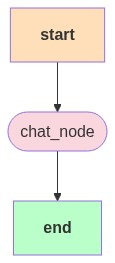

In [17]:
from IPython.display import Image, display
try:
  display(Image(chatbot.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [18]:
initial_state = {
    "messages": [HumanMessage(content="What is the capital of India")]
}

chatbot.invoke(initial_state)

{'messages': [HumanMessage(content='What is the capital of India', id='6eaecece-885c-4b20-a11e-3d4a156fb648'),
  AIMessage(content='The capital of India is **New Delhi**. \n', response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 15, 'total_tokens': 28, 'completion_time': 0.023636364, 'prompt_time': 0.00125267, 'queue_time': 0.25565605599999996, 'total_time': 0.024889034}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-959bad8c-6276-40b7-9c4e-d17010e028ce-0')]}

In [19]:
chatbot.invoke(initial_state)["messages"][-1].content

'The capital of India is **New Delhi**. \n'

In [ ]:
while True:
    user_input = input("Type here...")

    print("User: ",user_input)

    if user_input.strip().lower() in ["quit", "q", "exit", "bye"]:
        print("Chatbot: It's been great talking with you. Let me know if you have anything else to ask.")
        break

    response = chatbot.invoke({"messages":HumanMessage(content=user_input)})

    print("Chatbot: ", response["messages"][-1].content)

User:  Hi
Chatbot:  Hi! 👋

How can I help you today? 😊

User:  Who is India's Prime Minister
Chatbot:  The Prime Minister of India is **Narendra Modi**. 

User:  q
Chatbot: It's been great talking with you. Let me know if you have anything else to ask.


In [ ]:
while True:
    user_input = input("Type here...")

    print("User: ",user_input)

    if user_input.strip().lower() in ["quit", "q", "exit", "bye"]:
        print("Chatbot: It's been great talking with you. Let me know if you have anything else to ask.")
        break

    response = chatbot.invoke({"messages":HumanMessage(content=user_input)})

    print("Chatbot: ", response["messages"][-1].content)

User:  Hi
Chatbot:  Hi there! 👋  How can I help you today?

User:  My name is Benky
Chatbot:  Hello Benky! It's nice to meet you. 👋

What can I do for you today?

User:  What is my name?
Chatbot:  As an AI, I have no memory of past conversations and do not know your name. If you'd like to tell me, I'm happy to learn it!

User:  q
Chatbot: It's been great talking with you. Let me know if you have anything else to ask.


Everytime we call the invoke function the chatbotState will be set to empty, so it will not have any knowledge about our previous conversations

Store the previous chat in the RAM Memory

In [9]:
from langgraph.checkpoint.memory import MemorySaver

In [10]:
checkpointer = MemorySaver()

graph = StateGraph(ChatbotState)

graph.add_node("chat_node", chat_node)

graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", END)

chatbot = graph.compile(checkpointer=checkpointer)

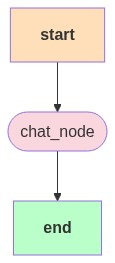

In [11]:
from IPython.display import Image, display
try:
  display(Image(chatbot.get_graph().draw_mermaid_png()))
except Exception:
  pass

Have a config variable to save the thread (unique for each user)

In [12]:
thread_id = "1"
while True:
    user_input = input("Type here...")

    print("User: ",user_input)

    if user_input.strip().lower() in ["quit", "q", "exit", "bye"]:
        print("Chatbot: It's been great talking with you. Let me know if you have anything else to ask.")
        break

    config = {"configurable": {"thread_id":thread_id}}

    response = chatbot.invoke({"messages":HumanMessage(content=user_input)}, config=config)

    print("Chatbot: ", response["messages"][-1].content)

User:  Hi
Chatbot:  Hi! 👋

How can I help you today? 😊

User:  My name is Benky
Chatbot:  Hi Benky! 👋

It's nice to meet you. What can I do for you?  😊

User:  What is my name
Chatbot:  Your name is Benky! 😊  

I remember that you told me.  

Is there anything else I can help you with? 😄

User:  Add 10 and 20
Chatbot:  10 + 20 = 30 😊 

Let me know if you have any other math problems for me! 🧮  

User:  Subtract 50 from it
Chatbot:  30 - 50 = -20 🧮 

Let me know if you have any other calculations you'd like me to do!  😊 

User:  Multiply it with negative 2
Chatbot:  -20 * -2 = 40  

You're getting good at this! 😊 

Do you have any more math problems for me? 🧠

User:  Multiply with -2
Chatbot:  40 * -2 = -80 

So the final answer is -80.  

Keep those math skills sharp! 💪

User:  q
Chatbot: It's been great talking with you. Let me know if you have anything else to ask.


In [13]:
chatbot.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi', id='d8610242-957d-40eb-867b-e0ff400f9849'), AIMessage(content='Hi! 👋\n\nHow can I help you today? 😊\n', response_metadata={'finish_reason': 'stop', 'logprobs': None, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'token_usage': {'completion_time': 0.027272727, 'completion_tokens': 15, 'prompt_time': 0.00117126, 'prompt_tokens': 10, 'queue_time': 0.25071718, 'total_time': 0.028443987, 'total_tokens': 25}}, id='run-9aa902c3-7a94-46f0-a8b9-aa1659e272df-0'), HumanMessage(content='My name is Benky', id='de71e979-6c4e-408d-90fb-03eb45d2c504'), AIMessage(content="Hi Benky! 👋\n\nIt's nice to meet you. What can I do for you?  😊\n", response_metadata={'finish_reason': 'stop', 'logprobs': None, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'token_usage': {'completion_time': 0.047272727, 'completion_tokens': 26, 'prompt_time': 0.00156121, 'prompt_tokens': 38, 'queue_time': 0.250236126, 'total